<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/LR_model_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook:
* Hyper-parameter tuning for LR using Grid Search cross validation
* Applying elastic net regularization (LASSO+Rigde) with 'saga' solver
* Running Logistic Regression with selected features from XGBooster algorithm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn import preprocessing

from imblearn.combine import SMOTETomek 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [ ]:
#Import Drive API and authenticate
from google.colab import drive
#Mount Drive to the Colab VM
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [ ]:
#Seperate the independent and dependent variables.
df_independent = df.drop(['Default'], axis=1)
df_default = df['Default']

In [ ]:
# split the data into 80% training+validation and 20% test
X_train, X_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.20, random_state=1) 

0    18670
1     5302
Name: Default, dtype: int64

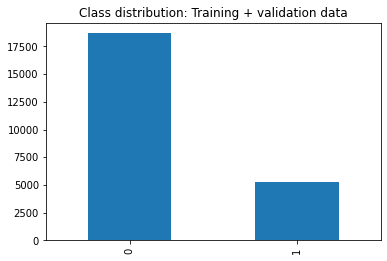

In [ ]:
#Make sure the distribution of the dependent variable is the same in both training+validation and test sets.
y_train.value_counts().plot(kind='bar', title='Class distribution: Training + validation data');
y_train.value_counts()    #22% defaulters in the training+validation data

0    4665
1    1328
Name: Default, dtype: int64

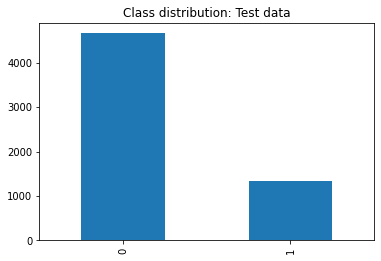

In [ ]:
# Test data
y_test.value_counts().plot(kind='bar', title='Class distribution: Test data')
y_test.value_counts() #22% defaulters in the test data

In [ ]:
# Scale input variables for training+validation (X_train)
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)

In [ ]:
# Balancing using SMOTE Tomek
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#hyperparameter adjustment with GridSearchCV
#NOTE: The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization or no regularization. The 'liblinear' solver supports both L1 and L2 regularization.
model = LogisticRegression(random_state=1)

solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty_options = ['l1','l2']
C_options = [0.1, 0.5, 1, 5, 10, 50, 100]

param_grid = dict(solver = solver_options, penalty = penalty_options, C = C_options)
grid = GridSearchCV(model, param_grid, cv=10, scoring = 'accuracy')
grid.fit(X_smt,y_smt)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
print (grid.best_params_) # {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
print (grid.best_score_) # output: 0.687

{'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
0.6872874268190688


In [ ]:
#Now use the optimized hyperparameters
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)    #5 repeats of k=10-fold
# create model
model = LogisticRegression(random_state=1, C= 0.5, penalty = 'l2', solver= 'newton-cg')
# evaluate model
scores = cross_val_score(model, X_smt, y_smt, scoring='accuracy', cv=cv, n_jobs=-1)   # will have 50 scores (5 iterations x 10-folds)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.688 (0.008)


In [ ]:
# Now also try elasticnet penalty with saga solver
# Can also use GridSearchCV  to find the optimal l1_ratio and C for elastic net + saga
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)    #5 repeats of k=10-fold
# create model
model = LogisticRegression(random_state=1, penalty = 'elasticnet', solver= 'saga', l1_ratio = 0.3)
# evaluate model
scores = cross_val_score(model, X_smt, y_smt, scoring='accuracy', cv=cv, n_jobs=-1)   # will have 50 scores (5 iterations x 10-folds)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.687 (0.008)


In [ ]:
#Finally test with the test set (X_test):
# Fit the model
model.fit(X_smt, y_smt)
# Predict using the scaled X_test
min_max_scaler = preprocessing.MinMaxScaler()
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

In [ ]:
# performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[4221  444]
 [ 759  569]]
accuracy 0.7992658101117971
precision 0.5616979269496545
recall 0.42846385542168675


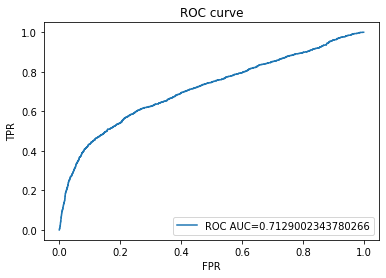

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = model.predict_proba(X_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="ROC AUC="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()

### Now run LR with selected features from XGBoost

In [ ]:
df_selected = df[['AGE', 'LIMIT_BAL', 'Pay_Apr', 'Repay_Sept', 'Pay_Sept','Default' ]]

In [ ]:
#Seperate the independent and dependent variables.
df_independent = df_selected.drop(['Default'], axis=1)
df_default = df_selected['Default']

In [ ]:
# split the data into 70% training + 30% test
X_train, X_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.30, random_state=1) 

In [ ]:
# Scale input variables for training
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)

In [ ]:
# Balancing the training data using SMOTE Tomek
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# create model
model = LogisticRegression(random_state=1, C= 0.5, penalty = 'l2', solver= 'newton-cg')   #optimized parameters from GridSearchCV
# Fit the model
model.fit(X_smt, y_smt)
# Predict using the scaled X_test
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

In [ ]:
# performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[5176 1805]
 [ 810 1199]]
accuracy 0.7091212458286985
precision 0.39913448735019974
recall 0.5968143354902937


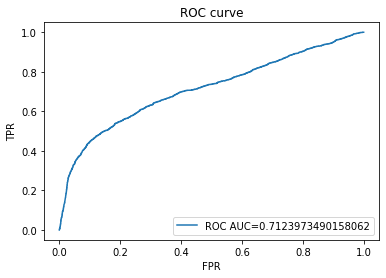

In [ ]:
# ROC curve, and ROC AUC
y_pred_proba = model.predict_proba(X_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="ROC AUC="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()